## Introdução

Neste exercício, nós implementaremos o algoritmo *backpropagation*, ou retropropagação, de redes neurais e o aplicaremos no mesmo problema do Desafio de Programação 3, isto é, no reconhecimento de dígitos numéricos manuscritos.


Todas as informações necessárias para resolver esta tarefa estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos o exercício, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy(https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico.

Mas antes, nós configuraremos o ambiente, permitindo o acesso ao seu Google Drive, de onde serão importados os datasets e as imagens do notebook, além de outros módulos adicionais.


A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.


In [1]:
#allows the drive to be accessed 
#from google.colab import drive

#drive.mount('/content/drive/')

In [2]:
#import sys

#!unzip -q "/content/drive/MyDrive/3° Semestre/IMLDL/Semana 4/Desafio de programacao 4/Utilidades-TP4.zip"
#!cat '/content/drive/MyDrive/3° Semestre/IMLDL/Semana 4/Desafio de programacao 4/utils.py'
#sys.path.append('/content/drive/MyDrive/3° Semestre/IMLDL/Semana 4/Desafio de programacao 4')

Com o acesso permitido ao drive e com o ambiente preparado, podemos iniciar a importação das bibliotecas de Python que serão utilizadas no nosso código. 

In [3]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Redes Neurais

No Desafio de Programação 3, nós implementamos a propagação *feedforward* em redes neurais para reconhecer dígitos manuscritos com os parâmetros fornecidos. Neste exercício, nós implementaremos o algoritmo *backpropagation* para treinar os parâmetros para a rede neural.

Primeiramente, carregaremos o dataset.

In [4]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Utilidades-TP4/Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualização dos dados

Nós iniciaremos com a visualização de uma parte dos nossos dados de treinamento utilizando a função `displayData`, que é a mesma que usamos no Desafio de Programação 3. Ela está disponível no arquivo `utils.py`. O dataset também é o mesmo do último desafio.

Existem 5000 exemplos de treinamento em `ex3data1.mat`, em que cada exemplo é uma imagem em escala de cinza de 20x20 pixels. Cada pixel é representado por um número (uma variável do tipo float) indicando a intensidade naquele local. A rede de 20x20 pixels é estendida em um vetor de comprimento igual a 400. Cada um desses exemplos de treinamento é colocado em uma linha da matriz `X`. Isto faz com que a matriz `X` tenha dimensão de 5000x400, em que cada linha é um exemplo de treinamento com a imagem do dígito numérico manuscrito.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

A segunda parte dos dados de treinamento é o vetor `y` de dimensão 5000x1 e contém as labels (o dígito correto presente em cada imagem). Ao executar a célula abaixo, nós visualizaremos alguns exemplos do nosso dataset.

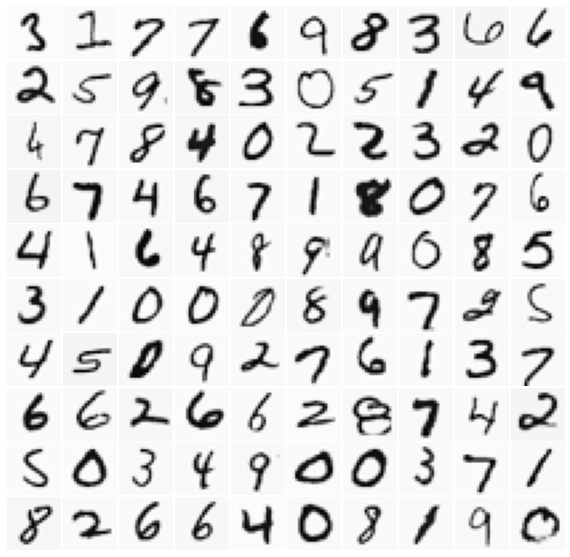

In [5]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Representação do modelo

Nossa rede neural está mostrada na figura seguinte.

![picture]( https://docs.google.com/uc?export=download&id=18sCrFfNkXBRJz-C3lyvPvqs0J3jg-44z)

Este modelo possui 3 camadas: Uma camada de entrada (*input layer*), uma camada oculta (*hidden layer*) e uma camada de saída (*output layer*). Relembre que as suas entradas são os valores de intensidade dos pixels da imagem do dígito. Sabendo que as imagens são do tamanho 20x20, isto resultará em uma camada de entrada de 400 unidades (excluindo uma unidade extra de *bias* que sempre gera +1). Como dito anteriormente, os dados de treinamento serão carregados nas variáveis `X` e `y`.

Você recebeu um conjunto de parâmetros da rede ($\Theta^{(1)}$, $\Theta^{(2)}$) já treinados por nós. Isto está guardado no arquivo `ex4weights.mat`. A próxima célula carrega os parâmetros em `Theta1` e `Theta2`. Os parâmetros possuem dimensões que estão arranjados para uma rede neural com 25 unidades na segunda camada e 10 unidades na camada de saída (correspondente às 10 classes).

In [6]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Utilidades-TP4/Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

<a id="section1"></a>
### 1.3 Feedforward e função de custo

Agora nós implementaremos a função de custo e o gradiente para a rede neural. Primeiramente, complete o código da função `nnCostFunction` na próxima célula para retornar o custo.

Atente-se que a função de custo para a rede neural (sem regularização) é:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

em que $h_\theta \left(x^{(i)} \right)$ é calculado como mostrado na figura da rede neural acima e K = 10 é o número de possíveis labels. Note que $h_\theta(x^{(i)})_k = a_k^{(3)}$ é a ativação (valor de saída) da $k^{th}$ unidade de saída. Atente-se, também, que enquanto as labels originais (na variável y) variam de 0 a 9, para o propósito de treinamento da rede neural, nós precisamos codificar as labels como vetores contendo apenas valores de 0 ou 1. Assim:
$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{ou} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

Para esse exemplo, se $x^{(i)}$ é uma imagem do dígito 5, então o $y^{(i)}$ correspondente (que você deve utilizar na função de custo) deve ser um vetor de comprimento 10 com $y_5 = 1$, e todos os outros elementos iguais a 0.

Você deve implementar a propagação *feedforward* que calcule $h_\theta(x^{(i)})$ para cada exemplo $i$ e somar o custo de todos os exemplos. **O seu código deve funcionar para um dataset de qualquer tamanho e com qualquer número de labels** (você pode assumir que sempre haverá ao menos $K \ge 3$ labels). Repare que a função define o termo de regularização `lambda_` mas ele ainda não deve ser utilizado. A regularização dessa função será pedida apenas na seção 1.4. 

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste Desafio de Programação.

In [7]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    subsX1 = X.copy()
    subsX1 = np.concatenate([np.ones((m,1)),subsX1],axis=1)
    subsX2_0 = subsX1@Theta1.T
    subsX2_1 = utils.sigmoid(subsX2_0)
    subsX2_1 = np.concatenate([np.ones((m,1)),subsX2_1],axis=1)
    subsX3_0 = subsX2_1@Theta2.T
    subsX3_1 = utils.sigmoid(subsX3_0)

    yA = np.zeros((m,num_labels))

    for c in range(0,m):
        yA[c,y[c]] = 1

    for k in range(0, num_labels):
        J = J + np.sum(-yA[:,k] * np.log(subsX3_1[:,k])-(1-yA[:,k])*np.log(1-subsX3_1[:,k]))

    J = J*(1/m)+lambda_/(2*m)*(np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))

    subsX3_1 -= yA

    Theta2_grad = (subsX3_1.T @ subsX2_1) / m + lambda_ * np.column_stack((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:])) / m

    subsX2_1 = subsX3_1 @ Theta2[:,1:] * (utils.sigmoid(subsX2_0)*(1-utils.sigmoid(subsX2_0)))

    Theta1_grad = (subsX2_1.T @ subsX1)/ m + lambda_ * np.column_stack((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]))/ m
    # ============================================================
    # Unroll gradients
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

Uma vez finalizada, chame a função `nnCostFunction` utilizando os parâmetros carregados para `Theta1` e `Theta2`. Você deve alcançar um custo por volta de 0.287629.

In [8]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


<a id="section2"></a>
### 1.4 Função de custo regularizada

A função de custo da rede neural com regularização é dada por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

Você pode assumir que a rede neural possui apenas 3 camadas - uma camada de entrada (*input layer*), uma camada oculta (*hidden layer*) e uma camada de saída (*output layer*). Entretanto, o seu código deve funcionar para qualquer número de unidades de entrada, unidades ocultas e unidades de saída. Enquanto nós listamos explicitamente os índices acima para $\Theta^{(1)}$ e $\Theta^{(2)}$ para maior clareza, note que o seu código deve funcionar de forma geral, com $\Theta^{(1)}$ e $\Theta^{(2)}$ de quaisquer dimensões.

Note que você não deve regularizar os termos que correspondem ao bias. Para as matrizes `Theta1` e `Theta2`, isto corresponde a primeira coluna de cada matriz. Você deve agora adicionar a regularização à função de custo. Repare que você pode calcular primeiro a função não regularizada $J$ utilizando a sua função `nnCostFunction` e, depois, adicionar os termos de regularização.

Uma vez finalizada, a próxima célula irá chamar `nnCostFunction` utilizando os parâmetros carregados de `Theta1` e `Theta2`, e $\lambda = 1$. Você deve obter um custo por volta de 0.383770.

In [9]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Custo para os parâmetros (carregados de ex4weights): %.6f' % J)
print('Este valor deve ser por volta de                   : 0.383770.')

Custo para os parâmetros (carregados de ex4weights): 0.383770
Este valor deve ser por volta de                   : 0.383770.


## 2 Backpropagation

Nesta parte do exercício, você irá implementar o algoritmo *backpropagation* para calcular o gradiente da função de custo da rede neural. Você irá atualizar a função `nnCostFunction` que então retornará um valor apropriado para `grad`. Uma vez que o gradiente tenha sido obtido, nós seremos capazes de treinar a rede neural para minimizar a função de custo $J(\theta)$ utilizando um otimizador avançado.

Você irá implementar primeiramente o algoritmo *backpropagation* para calcular o gradiente para os parâmetros da rede neural (não regularizada). Depois de verificar que o cálculo do gradiente para o caso não regularizado está correto, você irá implementar o gradiente para a rede neural regularizada.

<a id="section3"></a>
### 2.1 Gradiente Sigmoid

Para ajudar a iniciar com esta parte da tarefa, você inicialmente irá implementar o gradiente da função sigmoid. O gradiente para a função sigmoide pode ser calculado como

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

em que

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Agora complete a implementação de `sigmoidGradient` na próxima célula.
<a id="sigmoidGradient"></a>

A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste Desafio de Programação.

In [10]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    sigmoid = 1/(1 + np.exp(-z))
    g = sigmoid *(1-sigmoid)
    # ============================================================
    return g

Com isso finalizado, a próxima célula chamará `sigmoidGradient` no vetor `z`. Tente testar alguns valores chamando `sigmoidGradient(z)`. Para valores grandes (tanto positivos quanto negativos) de z, o gradiente deve se aproximar de 0. Quando $z = 0$, o gradiente deve ser exatamente 0,25. O código também deve funcionar para vetores bidimensionais e, nesse caso, a função deve executar a função `sigmoidGradient` em cada elemento.

In [11]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient avaliado em [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient avaliado em [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## 2.2 Inicialização randômica

Quando você treina redes neurais, é importante randomizar a inicialização dos parâmetros para quebrar a simetria. Uma estratégia efetiva para randomizar a inicialização é randomizar os valores selecionados de $\Theta^{(l)}$ uniformemente no intervalo de $[-\epsilon_{init}, \epsilon_{init}]$. Você deve utilizar $\epsilon_{init} = 0.12$. Este intervalo de valores garante que os parâmetros sejam mantidos baixos, o que torna o aprendizado mais eficiente.

<div class="alert alert-box alert-warning">
Uma estratégia efetiva para escolher $\epsilon_{init}$ é se basear no número de unidades da rede. Uma boa escolha de $\epsilon_{init}$ é $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ em que $L_{in} = s_l$ e $L_{out} = s_{l+1}$ é o número de unidades das camadas adjacentes para $\Theta^{l}$.
</div>

O seu trabalho é completar a função `randInitializeWeights` para inicializar os pesos para $\Theta$. Modifique a função preenchendo o seguinte código:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note que nós já fornecemos à função um argumento para $\epsilon$ com valor padrão `epsilon_init = 0.12`.

A correta implementação desta função lhe agregará **20 pontos** dentro da pontuação total deste Desafio de Programação.

In [12]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    # ============================================================
    return W

Execute a próxima célula para inicializar os pesos para as duas camadas da rede neural utilizando a função `randInitializeWeights`.

In [13]:
print('Inicializando os parâmetros da rede neural...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Inicializando os parâmetros da rede neural...


<a id="section4"></a>
### 2.4 Backpropagation

![](https://docs.google.com/uc?export=download&id=1PS7-OAd_XjKkrJTeW27_61mPfaFRZXwv)

Agora nós iremos implementar o algoritmo *backpropagation*. Relembre que a intuição por trás do algoritmo *backpropagation* é o seguinte. Dado um exemplo de treinamento $(x^{(t)}, y^{(t)})$, nós, primeiramente, executaremos uma passagem direta (*feedforward pass*) para calcular todas as ativações ao longo da rede, incluindo o valor de saída da hipótese $h_\theta(x)$. Assim, para cada nó $j$ na camada $l$, nós queremos calcular o "termo de erro" $\delta_j^{(l)}$ que mede o quanto o nó é "responsável" por qualquer erro na nossa saída.


Para um nó de saída, podemos medir diretamente a diferença entre a ativação da rede e o verdadeiro valor alvo e usá-lo para definir $\delta_j ^ {(3)}$ (já que a camada 3 é a camada de saída). Para as unidades ocultas, você calculará $\delta_j^{(l)}$ com base na média ponderada dos termos de erro dos nós na camada $ (l + 1) $. Você deve implementar as etapas de 1 a 4 em um loop que processa um exemplo de cada vez. Concretamente, você deve implementar um loop for `for t in range(m)` e colocar as etapas de 1 a 4 abaixo dentro do loop, com a  $t^{th}$ iteração executando o cálculo no $t^{th}$ exemplo de treinamento $(x^{(t)},y^{(t)})$. A Etapa 5 dividirá os gradientes acumulados por $m$ para obter os gradientes para a função de custo da rede neural.

1. Selecione os valores da camada de entrada $(a^{(1)})$ para os $t^{th }$ exemplos de treinamento $x^{(t)}$. Execute uma passagem direta, calculando as ativações $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ para as camadas 2 e 3. Note que você precisa adicionar um termo `+1` para se certificar que os vetores de ativação para as camadas $a^{(1)}$ e $a^{(2)}$ também incluem a unidade *bias*. Em `numpy`, se `a_1` é uma matriz coluna, adicionar uma coluna de `1` corresponde a `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. Para cada unidade de saída $ k $ na camada 3 (a camada de saída), defina 
$$\delta_k^{(3)} = \left (a_k^{(3)} - y_k \right)$$
em que $ y_k \in \{0, 1\} $ indica se o exemplo de treinamento atual pertence à classe $k$ $(y_k = 1)$ ou se pertence a uma classe diferente $ (y_k = 0) $. Você pode achar matrizes lógicas úteis para esta tarefa (explicadas no Desafio de Programação 3).

1. Para a camada oculta $ l = 2 $, defina
$$ \delta^{(2)} = \left (\Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Observe que o símbolo $ * $ realiza a multiplicação por elementos em `numpy`.

1. Acumule o gradiente deste exemplo usando a seguinte fórmula. Observe que você deve pular ou remover $ \delta_0^{(2)}$. Em `numpy`, remover $ \delta_0^{(2)} $ corresponde a `delta_2 = delta_2[1:] `.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)} (a^{(l)})^{(T)}$$

1. Obtenha o gradiente (não regularizado) para a função de custo da rede neural dividindo os gradientes acumulados por $ \frac{1} {m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$


Volte e atualize a função `nnCostFunction` com o algoritmo *backpropagation*.

Depois de implementar o algoritmo *backpropagation*, executaremos a verificação de gradiente em sua implementação. A verificação de gradiente aumentará a confiança de que seu código está calculando os gradientes corretamente.

### 2.4  Verificação do gradiente  

Na nossa rede neural, nós estamos minimizando a função de custo $J(\Theta)$. Para utilizar a verificação do gradiente nos nossos parâmetros, nós podemos imaginar que estamos "desenrolando" os parâmetros $\Theta^{(1)}$ e  $\Theta^{(2)}$ em um único vetor $\theta$. Ao fazer isso, nós podemos pensar na função de custo sendo $ J(\Theta) $ e usar o seguinte procedimento de verificação de gradiente.

Suponha que nós temos a função $f_i(\theta)$ que supostamente calcula $\frac{\partial}{\partial \theta_i} J(\theta)$; você gostaria de verificar se $ f_i $ está produzindo valores derivativos corretos.

$$
\text{Seja } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{e} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

Então, $\theta^{(i+)}$ é igual a $\theta$, com exceção do $i^{th}$ elemento, que foi acrescido por $\epsilon$. De maneira similar, $\theta^{(i−)}$ é igual ao vetor $\theta$, com exceção do $i^{th}$ elemento, que foi decrescido por $\epsilon$. Você pode agora verificar numericamente as correções dos $f_i(\theta)$’s, checando para cada $i$:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

O grau de proximidade entre esses dois valores depende de $J$. Mas, assumindo $ \epsilon = 10 ^ {- 4} $, você geralmente encontrará que os lados esquerdo e direito devem concordar pelo menos nos 4 dígitos mais significativos.

Nós já implementamos a função para calcular o gradiente numérico para você em `computeNumericalGradient` (que está dentro do arquivo `utils.py`). Apesar de você não precisar fazer nenhuma modificação no arquivo, nós recomendamos fortemente que você abra o código e entenda como ele funciona.

Na próxima célula nós iremos rodar a função fornecida `checkNNGradients` com a qual nós criaremos uma pequena rede neural e o dataset que será utilizado na verificação dos nossos gradientes. Se a sua implementação do algoritmo *backpropagation* está correta, você deverá ver uma diferença relativa (mostrada como *Relative Difference*) pequena, algo por volta de 1e-9.

<div class="alert alert-box alert-success">
**Dica Prática:** Quando executarmos a verificação do gradiente, é muito mais eficiente utilizar uma rede neural pequena com um pequeno número de unidades na camada de entrada e na camada oculta, assim, teríamos um pequeno número de parâmetros. Cada dimensão de $\theta$ precisa de duas avaliações da função de custo e isso tem um custo computacional relativamente alto. Na função `checkNNGradients`, o nosso código cria um pequeno modelo randômico e um dataset que é utilizado em `computeNumericalGradient` para verificação do gradiente. Além disso, após você se sentir confiante de que o seu cálculo do gradiente está correto, você deve desligar a verificação do gradiente antes de rodar o seu algoritmo de aprendizagem.
</div>

<div class="alert alert-box alert-success">
**Dica prática:** A verificação do gradiente funciona para qualquer função em que você está calculando o custo e o gradiente. De forma concreta, você pode utilizar a mesma função `computeNumericalGradient` para checar se a suas outras implementações do gradiente para outros desafios de programação também estão corretas.    
</div>

In [14]:
utils.checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978931e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146356e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149705e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883213e-05  3.69883234e-05]
 [ 3.35320347e-04  3.35320347e-04]
 [ 1.53247079e-04  1.53247082e-04]
 [-6.74798370e-03 -6.74798370e-03]
 [-4.68759787e-05 -4.68759769e-05]
 [-3.76215588e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736493e-02  5.75736493e-02]
 [ 5.77867378e-02  5

<a id="section5"></a>
### 2.5 Rede Neural Regularizada

Após implementar o algoritmo *backpropagation* corretamente, nós iremos adicionar a regularização do gradiente. Para se levar em conta a regularização, basta adicionar um termo adicional depois de calcular os gradientes utilizando o algoritmo *backpropagation*.

Especificamente, após o cálculo de $\Delta_{ij}^{(l)}$ utilizando o algoritmo *backpropagation*, você deve adicionar a regularização utilizando

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note que você NÃO deve regularizar a primeira coluna de $\Theta^{(l)}$, já que ela é utilizada para acomodar os termos bias. Além disso, nos parâmetros $\Theta_{ij}^{(l)}$, $i$ é indexado iniciando-se em 1 e $j$ é indexado iniciando-se em 0. Assim,

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

Agora, modifique o código que calcula o gradiente em `nnCostFunction`, levando em conta a regularização.

Depois de finalizado, a próxima célula executará a verificação do gradiente na sua implementação. Se o seu código estiver correto, você deve obter uma diferença relativa abaixo de $10^{-9}$.

In [15]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813550e-03  7.62813551e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798370e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101547e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928666e-05  3.81928696e-05]
 [ 1.17148233e-01  1

### 2.6 Aprendizagem dos parâmetros utilizando `scipy.optimize.minimize`

Após implementar a função de custo da rede neural e o cálculo do gradiente, o próximo passo é utilizar a minimização de `scipy` para fazer a aprendizagem de bons parâmetros.

In [16]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

Depois de completar o treinamento, nós iremos calcular a acurácia de treinamento do nosso classificador através do cálculo da porcentagem de exemplos corretos. Se a sua implementação estiver certa, você deverá obter uma acurácia de treinamento em torno de 95,3% (isto pode variar em aproximadamente 1% devido a inicialização randômica). É possível obter acurácias maiores treinando a rede neural em mais iterações.

Nós recomendamos você a tentar treinar a rede neural para mais iterações, selecionando`maxiter` = 400, além de também tentar variar o parâmetro de regularização $\lambda$ .

In [17]:
pred = utils.predict(Theta1, Theta2, X)
print('Acurácia de treinamento: %f' % (np.mean(pred == y) * 100))

Acurácia de treinamento: 95.980000


## 3 Visualizando a Camada Oculta

Uma forma de entender o que a rede neural está aprendendo é visualizar quais são as representações capturadas pelas unidades da camada oculta. De maneira informal, dada uma unidade particular da camada oculta, uma forma de visualizar o que está sendo calculado é encontrar uma entrada $x$ que fará com que ela seja ativada (ou seja, tenha um valor de ativação ($ a_i^{(l)} $) próximo a 1). Para a rede neural que nós treinamos, perceba que a $i^{th}$ linha de $\Theta^{(1)}$ é um vetor de tamanho igual a 401 que representa o parâmetro para a $i^{th}$ unidade da camada oculta. Se nós descartamos o termo *bias*, nós teremos um vetor de tamanho 400 que representa os pesos de cada pixel de entrada da camada oculta.

Assim, uma forma de visualizar a "representação" capturada pela unidade da camada oculta é remodelar este vetor de tamanho 400 em uma imagem 20x20 e mostrá-la (isso é equivalente a encontrar a entrada que oferece a maior ativação para a unidade oculta, dada uma restrição de "norma" na entrada (ou seja, $ ||x||_2 \le 1 $))).

A próxima célula faz isso utilizando a função `displayData` e isso é mostrado em uma imagem com 25 unidades, cada uma correspondendo a uma unidade da camada oculta da rede. Na nossa rede treinada, você deve encontrar que as unidades da camada oculta correspondem, de forma grosseira, aos detectores que procuram traços e outros padrões na entrada.

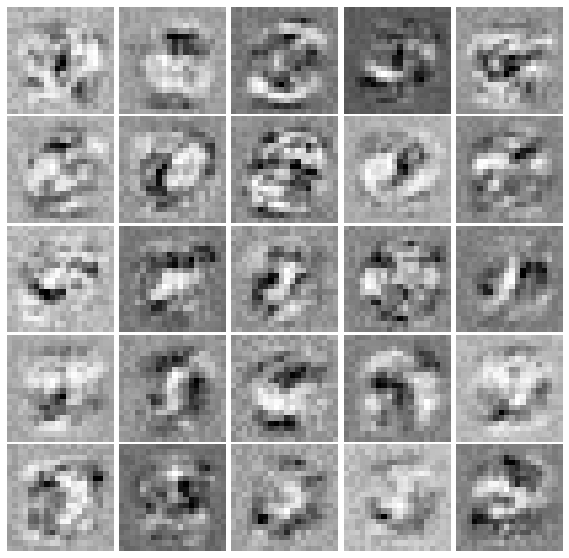

In [18]:
utils.displayData(Theta1[:, 1:])

# 4 Comparação com Pytorch

Agora, nós construiremos a mesma rede neural para classificação apresentada nas seções anteriores, mas ao invés de construir as funções que executam cada passo da rede neural, nós utilizaremos as funções disponíveis na Bibiloteca Pytorch.

Essa biblioteca é uma ferramenta de *machine learning* que disponibiliza diversas funções que simplificam a criação de um modelo de inteligência artificial, acelerando na elaboração dos códigos.

Nesta seção, nós criaremos uma rede neural simples com o intuito de aprender as funções básicas dessa biblioteca.  
              

Primeiramente vamos importar a biblioteca Pytorch.

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

### 4.1 Criação do modelo

A estrutura da nossa rede neural será a mesma daquela apresentada na subseção 1.2, em que temos uma camada de entrada, uma camada oculta e uma camada de saída. Construiremos agora essa rede utilizando o Pytorch. Relembrando a estrutura, temos:

- Uma camada de entrada com função de ativação Linear com:

        -> Input: 400     
        -> Output: 25
        -> Bias: True 
    
- Uma camada oculta com função de ativação Sigmoid com: 

        -> Input: 25 
        -> Output: 10 
        -> Bias: True
    
- E a camada de saída que contém as saídas com as 10 classes esperadas (uma para cada dígito).


Sendo assim, construiremos a nossa rede neural a partir da classe NeuralNetwork. Essa classe é inicializada definindo as funções `fc1` e `fc2` que executam transformações lineares nos dados em cada camada, sendo que a primeira ocorre na camada de entrada (com 400 entradas e 25 saídas) e a segunda na camada oculta (com 25 entradas e 10 saídas).

Na sequência definiremos a função forward() que executa a função Sigmoid como as funções de ativação das duas camadas em questão. 

In [20]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        #The super() builtin returns a proxy object (temporary object of the superclass) that allows us to access methods of the base class.
        super().__init__()
        #fc1 and fc2 will be our layers
        self.fc1 = torch.nn.Linear(in_features=400, out_features=25, bias=True)
        self.fc2 = torch.nn.Linear(in_features=25, out_features=10, bias=True)
    def forward(self, out):
        # foward() will perform linear activation on each layer
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

### 4.2 Processamento e tratamento dos dados de entrada

Uma vez criada a estrutura da rede neural, nós precisamos fazer o processamento dos dados de entrada, adequando-os para um formato em que a classe que criamos possa processá-los para fazer a aprendizagem dos parâmetros da rede.

Inicialmente, nós vamos reimportar os dados do Desafio de Programação, readequando o ponteiro dos dados, já que na linguagem MATLAB ele é inicializado em 1 e em Python em 0.

In [21]:
# Import the data
datas = loadmat('Utilidades-TP4/Data/ex4data1.mat')
datas.keys()

label, images = datas['y'], datas['X']
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
label = label - 1

Com os dados importados e basicamente ajustados, nós transformá-lo-emos em tensores antes de criarmos o dataset. Para isso, nós utilizaremos os métodos `torch.Tensor()` e `torch.LongTensor()`. A diferença entre os dois é apenas a de que o primeiro aceita valores do tipo `float` (mais especificamente `float32`) enquanto o segundo aceita valores do tipo `int` (mais especificamente `int64`).



In [22]:
# Transform the inputs and labels into tensors
tensor_images, tensor_label = torch.Tensor(images), torch.LongTensor(label)

Feito isso, nós já podemos criar o nosso dataset que será utilizado no treinamento da rede neural. Para isso nós utilizaremos as funções `TensorDataset` e `DataLoader`.

Nessas funções, nós selecionaremos o tamanho desejado para o *batch*, além da opção de embaralhar (*shuffle*) os dados para melhorar a performance da rede neural.  

In [23]:
# Batch Size
batch_size = 35

# Creating the dataset with the two tensors
dataset = TensorDataset(tensor_images, tensor_label)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 4.3 Treinamento da Rede Neural

Para o treinamento da rede neural é preciso escolher qual função de custo será utilizada e qual será o algoritmo de otimização dos parâmetros da rede.

O Pytorch disponibiliza vários tipos de função de custo dentro do módulo `torch.nn`. Entre os mais conhecidos estão a *Cross Entropy* e o Erro Quadrático Médio (*mean squared error*). A documentação de todas essas funções de erro que o Pytorch fornece estão disponíveis [neste link](https://pytorch.org/docs/stable/nn.html#loss-functions).

Quanto ao algoritmo de otimização, a biblioteca também disponibiliza diversos tipos, entre os mais conhecidos estão o *Gradient Descedent*, o *Stochastic Gradient Descedent* e o Adam. A documentação destes e de outros algoritmos de otimização estão disponíveis [neste link](https://pytorch.org/docs/stable/optim.html#algorithms).

No nosso programa, os escolhidos foram a *Cross Entropy* para função de custo e, como algoritmo de otimização, foi escolhido o *Stochastic Gradient Descedent* com valores iniciais de *learning rate* de 0.5 e *momentum* de 0.9.

Com tudo configurado, podemos instanciar a nossa rede neural na variável `model`

In [24]:
# Instantiate the NN into variable model
model = NeuralNetwork()

# Definition of cost function
criterion = torch.nn.CrossEntropyLoss()

# Definition of SGD as optimizer algorithm and its parameter sets
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)

Printaremos a variável `model` para que possamos visualizar os seus detalhes.

In [25]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


Uma vez que os dados de treino estão processados corretamente e o modelo está devidamente instanciado com função de custo e algoritmo de otimização configurados, devemos construir o loop de treinamento da rede.

Nós escolheremos, primeiramente, o número de épocas pelo qual a nossa rede neural passará nessa etapa de treinamento. Em cada uma dessas épocas, a rede neural deve criar outro loop em que cada exemplo do dataloader será explorado, calculando o erro e otimizando os parâmetros ao final de cada um desses exemplos.

Para isso, nós já criamos abaixo os dois loops. A sua tarefa é escrever um código que permita que o algoritmo calcule a função de custo e, a partir dela, otimize os parâmetros da rede neural. 

**ATENÇÃO:** a função de custo deve ser calculada na variável de nome `cost` e a saída da rede neural deve ser guardada na variável `output`, já que são estas variáveis que serão utilizadas posteriormente para a plotagem dos gráficos.

A correta implementação desta função lhe agregará **40 pontos** dentro da pontuação total deste Desafio de Programação.

In [26]:
def training(NN, dataloader, criterion, lr=0.5):
    """
    Train the neural network to improve the predictions and, consequently,
    the accuracy os the model.

    Parameters
    ----------
    NN : class_like
        A class that contains the structure of neural network. 

    dataloader: class_like
        A class that contains the training data set with images and labels.
    
    criterion: class_like
        A class that contains the cost function.
    
    lr: float_like
        The number of the learning rate. By default, it is equal to 0.5.

    Returns
    --------
    costs : list_like
        List of cost function values ​​for each epoch.

    accs : list_like
        List of accuracy values for each epoch. 
    
    Instructions
    ------------
    Train the network using the functions of the Pytorch library.

    Note
    ----
    We provide the implementation of the accuracy computation, 
    as well as the construction of the lists costs and accs.
    """

    # Recreates the model and the optimizer to ensure that we will not train an already trained model.
    model = NN
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Define the number os epochs.
    num_epochs = 100

    cost = torch.zeros([])
    output = torch.zeros(batch_size,10)
    costs = []
    accs = []

    # Loop that will run the code num_epoch times
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        model.train()
        for data,label in dataloader:
          
            # ====================== YOUR CODE HERE ======================
            output = model(data)
            cost = criterion(output, label.flatten())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()               
            # ============================================================
          
            # Counting of correct labels and total examples
            out2 = (torch.log_softmax(output,dim=1))
            _,predict = torch.max(out2, dim = 1)
            for i in range(0,len(label)):
              total = total + 1
              if predict[i] == label[i]: 
                correct = correct + 1

        # Computation of accuracy
        acc = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem

        # Adding elements to lists
        accs.append(acc) #Adiciona essa acurácia a sua lista
        costs.append(cost.item())

        print('epoch [{}/{}], cost:{:.4f}'.format(epoch + 1, num_epochs, cost.item()))

    return costs, accs

Na função `training` nós executamos o treinamento da rede neural e, dentro do loop, nós já coletamos os valores da função de custo e da acurácia em cada época, guardando-os em duas listas que são retornadas ao final da nossa função.

In [27]:
costs, accs = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion)

epoch [1/100], cost:1.7119
epoch [2/100], cost:1.5947
epoch [3/100], cost:1.5785
epoch [4/100], cost:1.5463
epoch [5/100], cost:1.5298
epoch [6/100], cost:1.6003
epoch [7/100], cost:1.5431
epoch [8/100], cost:1.5313
epoch [9/100], cost:1.5237
epoch [10/100], cost:1.5272
epoch [11/100], cost:1.5385
epoch [12/100], cost:1.5646
epoch [13/100], cost:1.5321
epoch [14/100], cost:1.4979
epoch [15/100], cost:1.4710
epoch [16/100], cost:1.4852
epoch [17/100], cost:1.5357
epoch [18/100], cost:1.4682
epoch [19/100], cost:1.5705
epoch [20/100], cost:1.5115
epoch [21/100], cost:1.5213
epoch [22/100], cost:1.5315
epoch [23/100], cost:1.5009
epoch [24/100], cost:1.5124
epoch [25/100], cost:1.5027
epoch [26/100], cost:1.5145
epoch [27/100], cost:1.4780
epoch [28/100], cost:1.4751
epoch [29/100], cost:1.4703
epoch [30/100], cost:1.5640
epoch [31/100], cost:1.4719
epoch [32/100], cost:1.4742
epoch [33/100], cost:1.5041
epoch [34/100], cost:1.5927
epoch [35/100], cost:1.4719
epoch [36/100], cost:1.5387
e

Com a rede treinada, podemos plotar os valores da função de custo em função do número de épocas, para que possamos analisar o comportamento dela e visualizarmos se houve a convergência esperada.

A célula abaixo plotará os dois gráficos (da função de perda e da acurácia). É esperado que, ao final das 100 épocas, a função de perda esteja entre 1.45 e 1.55 e a acurácia esteja acima de 95%.  

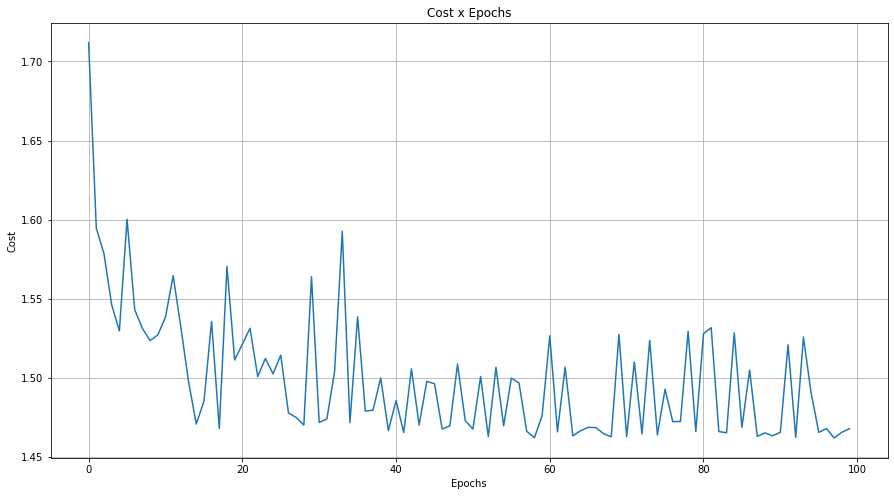

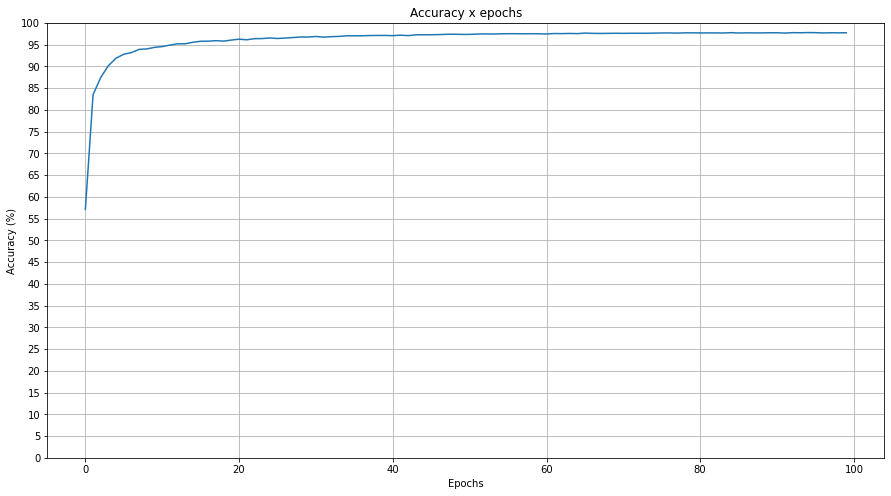

In [28]:
pyplot.figure(figsize=(15,8))
pyplot.plot(costs)
pyplot.title('Cost x Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.grid(True)
pyplot.show()

pyplot.figure(figsize=(15,8))
pyplot.plot(accs)
pyplot.yticks(range(0,101,5))
pyplot.title('Accuracy x epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy (%)')
pyplot.grid(True)
pyplot.show()


Veremos agora como essas duas curvas se comportam ao alterarmos o valor do *learning rate*. Treinaremos a rede agora com diferentes valores de `lr`: `lr=0.005`, `lr=0.015`, `lr=15` e `lr=50`.

In [29]:
costs_lr0005, accs_lr0005 = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr = 0.005)
costs_lr0015, accs_lr0015 = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr = 0.015)
costs_lr15, accs_lr15 = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr = 15)
costs_lr50, accs_lr50 = training(NN=NeuralNetwork(), dataloader=dataloader, criterion=criterion, lr = 50)

epoch [1/100], cost:2.3073
epoch [2/100], cost:2.2982
epoch [3/100], cost:2.2820
epoch [4/100], cost:2.2745
epoch [5/100], cost:2.2789
epoch [6/100], cost:2.2645
epoch [7/100], cost:2.2603
epoch [8/100], cost:2.2360
epoch [9/100], cost:2.2259
epoch [10/100], cost:2.2304
epoch [11/100], cost:2.1801
epoch [12/100], cost:2.1581
epoch [13/100], cost:2.1471
epoch [14/100], cost:2.0899
epoch [15/100], cost:2.0829
epoch [16/100], cost:2.0745
epoch [17/100], cost:2.0441
epoch [18/100], cost:2.0486
epoch [19/100], cost:2.0579
epoch [20/100], cost:1.9956
epoch [21/100], cost:1.9942
epoch [22/100], cost:1.9676
epoch [23/100], cost:1.9378
epoch [24/100], cost:1.9085
epoch [25/100], cost:1.9321
epoch [26/100], cost:1.9653
epoch [27/100], cost:1.9431
epoch [28/100], cost:1.8711
epoch [29/100], cost:1.8695
epoch [30/100], cost:1.8452
epoch [31/100], cost:1.8413
epoch [32/100], cost:1.8384
epoch [33/100], cost:1.8204
epoch [34/100], cost:1.8136
epoch [35/100], cost:1.8539
epoch [36/100], cost:1.8240
e

epoch [95/100], cost:1.5586
epoch [96/100], cost:1.6068
epoch [97/100], cost:1.6096
epoch [98/100], cost:1.5310
epoch [99/100], cost:1.6497
epoch [100/100], cost:1.6395
epoch [1/100], cost:2.2603
epoch [2/100], cost:2.1520
epoch [3/100], cost:2.1852
epoch [4/100], cost:2.3387
epoch [5/100], cost:2.2290
epoch [6/100], cost:2.3591
epoch [7/100], cost:2.4257
epoch [8/100], cost:2.3924
epoch [9/100], cost:2.5580
epoch [10/100], cost:2.4257
epoch [11/100], cost:2.4257
epoch [12/100], cost:2.5924
epoch [13/100], cost:2.3257
epoch [14/100], cost:2.3924
epoch [15/100], cost:2.4591
epoch [16/100], cost:2.5924
epoch [17/100], cost:2.5257
epoch [18/100], cost:2.3591
epoch [19/100], cost:2.4924
epoch [20/100], cost:2.1924
epoch [21/100], cost:2.3591
epoch [22/100], cost:2.3924
epoch [23/100], cost:2.5924
epoch [24/100], cost:2.4591
epoch [25/100], cost:2.4591
epoch [26/100], cost:2.2924
epoch [27/100], cost:2.2924
epoch [28/100], cost:2.3591
epoch [29/100], cost:2.3591
epoch [30/100], cost:2.3924


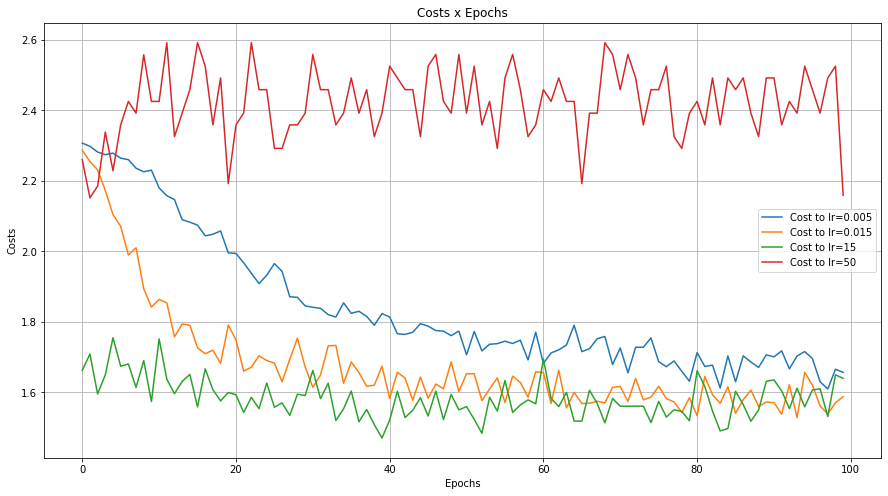

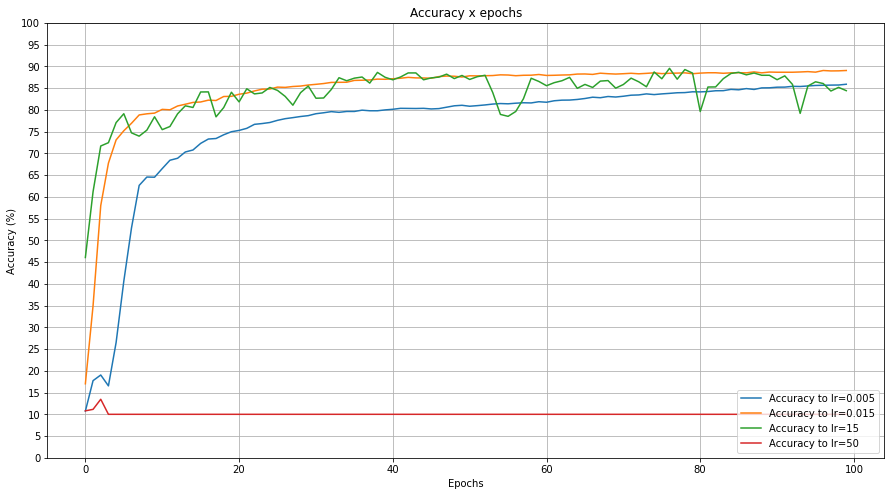

In [30]:
pyplot.figure(figsize=(15,8))
pyplot.plot(costs_lr0005, label='Cost to lr=0.005')
pyplot.plot(costs_lr0015, label='Cost to lr=0.015')
pyplot.plot(costs_lr15, label='Cost to lr=15')
pyplot.plot(costs_lr50, label='Cost to lr=50')
pyplot.title('Costs x Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Costs')
pyplot.legend()
pyplot.grid(True)
pyplot.show()

pyplot.figure(figsize=(15,8))
pyplot.plot(accs_lr0005, label='Accuracy to lr=0.005')
pyplot.plot(accs_lr0015, label='Accuracy to lr=0.015')
pyplot.plot(accs_lr15, label='Accuracy to lr=15')
pyplot.plot(accs_lr50, label='Accuracy to lr=50')
pyplot.yticks(range(0,101,5))
pyplot.title('Accuracy x epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy (%)')
pyplot.legend(loc='lower right')
pyplot.grid(True)
pyplot.show()

Veja como o algoritmo nos dois casos em que `lr` é muito pequeno convergem, mas lentamente, de forma que após as 100 épocas, a acurácia ainda não passou dos 95%.

Para `lr=15` o algoritmo converge, mas, analisando a forma das duas curvas (custo e acurácia), parece estar no limiar entre a convergência e a divergência. Apesar de a sua função de perda ficar em um valor aceitável ao final das 100 épocas, a acurácia deixa claro que o seu desempenho é pior do que para `lr=0.5`, uma vez que esta não ultrapassa o valor de 90%.  

Por outro lado, para `lr=50` o algoritmo não converge. É interessante perceber o comportamento da curva da acurácia deste modelo. Com a divergência, o algoritmo não consegue melhorar os seus parâmetros e, assim, é como se ele tentasse adivinhar os labels de forma aleatória. Nesse caso, como os dados são divididos em 10 classes equiprováveis, é esperado que o valor de acurácia seja aproximadamente 10%, e é exatamente isso que acontece durante todas as épocas.
